In [332]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

9.456657e-05
0.00010330881


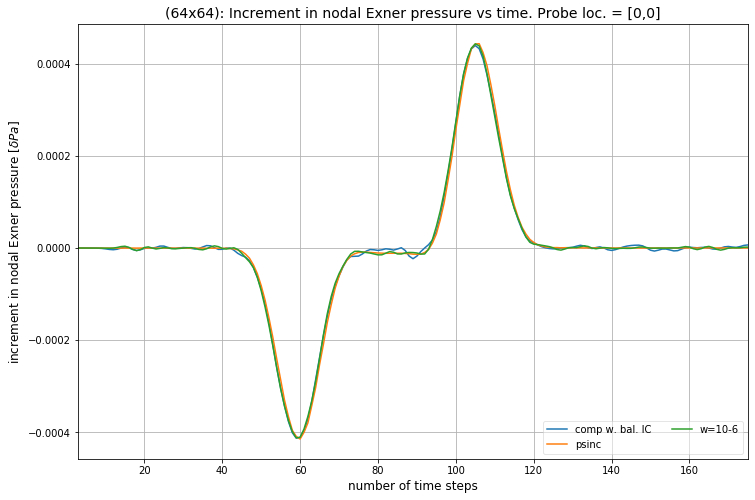

In [121]:
base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex/w-16/"
py_directory = "../%s/" %directory

Nx = 64
Ny = 64
et = 1.0

tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

steps = np.arange(176) # 64x64
# steps = np.arange(355) # 128x128
# steps = np.arange(711) # 256x256
# steps = steps[74:93] # 64x64
# steps = steps[155:185] # 128x128
# steps = steps[329:381] # 256x256
steps = steps[2:]
probe_loc = [0,0]

comp = []
psinc = []

attribute = 'p2_nodes'
diff = True

def get_cbs(cbs,cbs_suffix):
    cb_suffix = tc.cb_suffix(cbs[0],cbs[1],cbs_suffix)
    return [(tc.get_time_series(steps,1,attribute,cb_suffix,probe_loc,label_type='STEP',diff=diff))]

comp.append(tc.get_time_series(steps,1,attribute,'comp',probe_loc,label_type='STEP',diff=diff))
psinc.append(tc.get_time_series(steps,1,attribute,'psinc',probe_loc,label_type='STEP',diff=diff))

comp = comp[0]
psinc = psinc[0]

norm = np.linalg.norm(comp-psinc)
print(norm)

steps_axs = steps[1:]
fig = plt.figure(figsize=(12,8))
plt.plot(steps_axs, comp, '-', label='comp w. bal. IC')
plt.plot(steps_axs, psinc, label='psinc')

end_weight = 16+1 # 16+1, 24+1
start_weight = 0 # 0, 16
intervals = 2 # 2, 1
weight = 16 # 16, 32

start_weight = 10
end_weight = 12

for i,w in enumerate(range(start_weight,end_weight,intervals)):
    cbs, cbs_suffix = [1,0], 'w=%i-%i' %(w,weight-w)
    cb = get_cbs(cbs,cbs_suffix)[0]
    norm = np.linalg.norm(cb-psinc)
    if True:
        plt.plot(steps_axs, cb, label='%s' %(cbs_suffix))
    else:
        plt.plot(steps_axs, cb, label='%s' %(cbs_suffix))
    print(norm)
# cbs, cbs_suffix = [1,0], ''
# cb = get_cbs(cbs,cbs_suffix)[0]
# plt.plot(steps_axs, cb, label='%s' %(cbs_suffix))
    
plt.ylabel('increment in nodal Exner pressure [$\delta Pa$]', fontsize='12')
plt.xlabel('number of time steps', fontsize='12')
plt.title("(%ix%i): Increment in nodal Exner pressure vs time. Probe loc. = [%i,%i]" %(Nx,Ny,probe_loc[0],probe_loc[1]), fontsize='14')
# txt = '''
#         fc: fully compressible; cb: continuous blending
#         fs: full time-step in pseudo-incompressible solve
#         ts: no. of transition steps to fully-compressible
#         '''
# fig.text(.51,.12,txt,fontsize='12')
plt.xlim([steps_axs[0],steps_axs[-1]])
plt.legend(ncol=2,loc='lower right', framealpha=0.5)
plt.grid()
plt.show()

In [140]:
e1 = 9.456657e-05
e2 = 3.4011202e-05
e3 = 8.7309145e-06

# e1 = 0.00010330881
# e2 = 3.5739944e-05
# e3 = 8.854217e-06


# e1 = 3.1681833e-05
# e2 = 3.844869e-06
# e3 = 8.2637905e-07

u1 = e1-e2
u2 = e2-e3
np.log2(u1/u2)

print(np.isclose(10e-7, 1e-6))
# print(1e-5 - 0.0001)

True


In [88]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    arr = arr[2:-2,2:-2]
    ref = ref[2:-2,2:-2]
    
    arr -= arr.mean()
    ref -= ref.mean()
    
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME', tag='after_full_step'):
#     inner = (slice(2,-2),slice(2,-2))
    inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.3f_%s' %(n,time, tag)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_%s' %(time, tag)
            else:
                t_label = '_ensemble_mem=%i_%.3d_%s' %(n,time, tag)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

def rmse(diff):
    return np.sqrt((diff**2).mean())

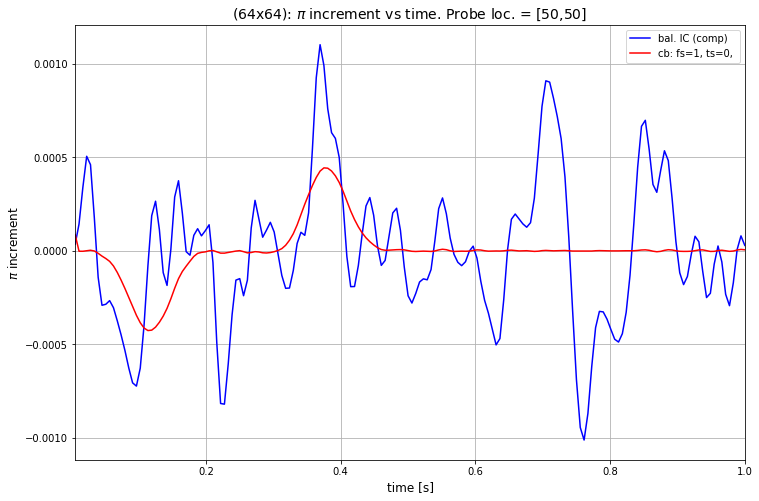

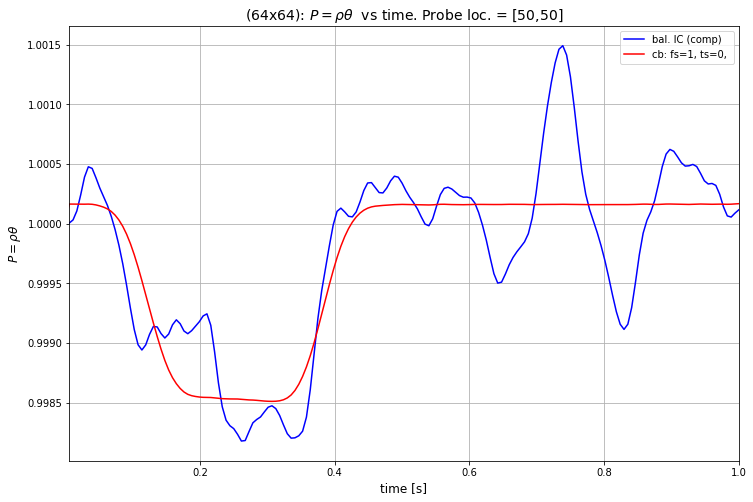

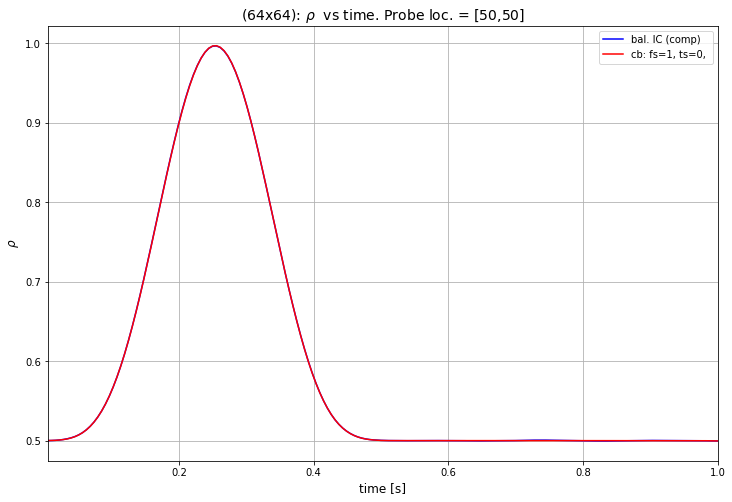

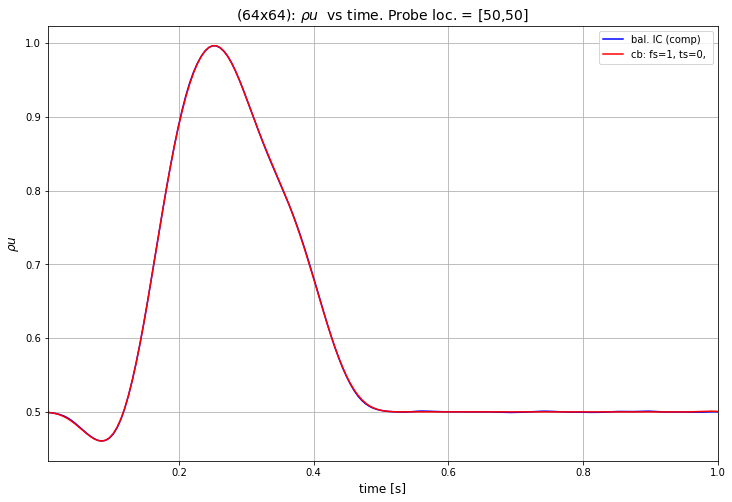

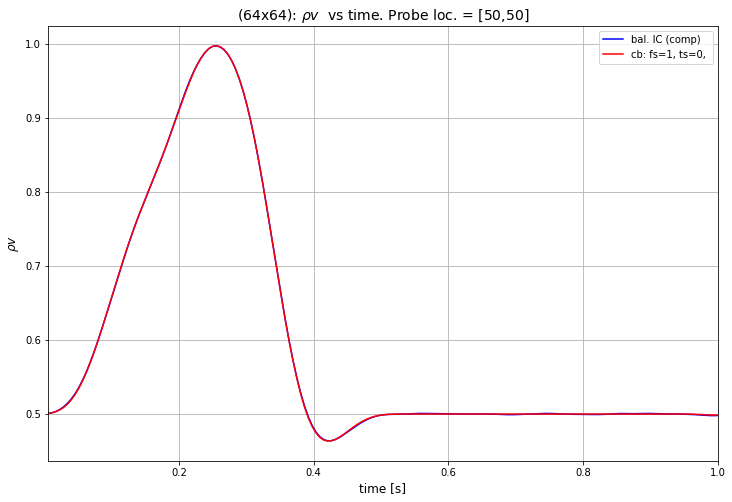

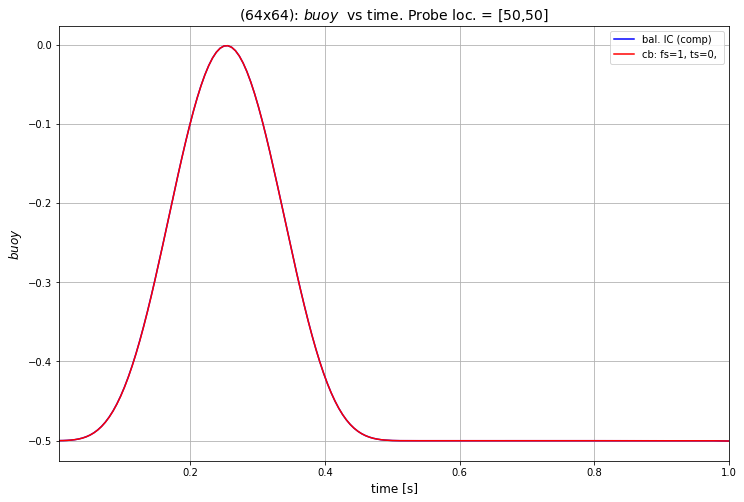

In [57]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, tag, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, tag=tag, label_type='STEP')

Ns = 176
Ns_full = 176
# Ns = 199
# Ns_full = 199
# Ns, Ns_full = 528, 528
times = np.arange(0,Ns+1)
# times = times[98:115]
# times = times[109:116]
# times = times[94:101]
# times = times[70:100]
# times = times[-60:]
# times = times[:50]
dt = end_time / Ns_full
times_axis = times * dt

# times_axis = times_axis[::2]
# print(times_axis)

probe_row = 50
probe_col = 50
attributes = ['p2_nodes', 'rhoY', 'rho', 'rhou', 'rhov', 'buoy']
attributes_str = {
    'p2_nodes': r'$\pi$',
    'rhoY' : r'$P = \rho \theta$',
    'rho' : r'$\rho$',
    'rhou' : r'$\rho u$',
    'rhov' : r'$\rho v$',
    'buoy' : r'$buoy$',
}
cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [10,0], ''
cb3, cb3_suffix = [20,0], ''

# cb1, cb1_suffix = [1,0], '_conversion_1'
# cb2, cb2_suffix = [1,0], '_conversion_2'
# cb3, cb3_suffix = [1,0], '_no_conversion'

cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [1,0], '_method_1'
cb3, cb3_suffix = [1,0], '_method_2'

# cb1, cb1_suffix = [0,5], ''
# cb2, cb2_suffix = [0,10], ''
# cb3, cb3_suffix = [0,20], ''

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    tag = 'before_flux'
#     tag = 'before_advect'
#     tag = 'after_advect'
#     tag = 'after_ebnaexp'
#     tag = 'after_ebnaimp'
#     
    tag = 'after_half_step'
#     tag = 'after_efna'
#     tag = 'after_full_ebnaexp'
    tag = 'after_full_step'
    
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        
#         arr -= arr.mean()
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    if attribute == 'p2_nodes' and increment == True:
        probe = np.diff(probe)
    return probe
    
# times_axis = times#np.arange(0,Ns+1)

increment = True
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""
        
#     probe = get_time_series(times,attribute,"_truth")
#     probe_th = get_time_series(times,attribute,"_truth_half_two")
    probe_fc = get_time_series(times,attribute,"_comp")
#     probe_fc = get_time_series(times,attribute,"_hypo")
#     probe_psinc = get_time_series(times,attribute,"_psinc")

#     probe_th = np.diff(probe_psinc)
#     probe_th = (probe_psinc[1:] + probe_psinc[:-1]) * 0.5
    probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     probe_cb2 = get_time_series(times,attribute,cb2_suffix,cont_blend=True,fs=cb2[0],ts=cb2[1])
#     probe_cb3 = get_time_series(times,attribute,cb3_suffix,cont_blend=True,fs=cb3[0],ts=cb3[1])

    fig1 = plt.figure(figsize=(12,8))
#     plt.plot(t_axs,probe, '-', label='bal. IC (comp)', c='b')
#     plt.plot(t_axs-1.0+1./16,probe_th, '-', label='bal. IC', c='k')
#     probe_psinc = (3.0 * probe_psinc[:-1] + probe_psinc[1:]) / 4.0
    plt.plot(t_axs,probe_fc, '-', label='bal. IC (comp)', c='b')
#     plt.plot(t_axs,probe_psinc, '-', label='imbal. IC (psinc)', c='g')
#     cb1_suffix = ' "1/4 + 3/4" strategy for $\pi$ conversion'
    plt.plot(t_axs,probe_cb1, '-', label='cb: fs=%i, ts=%i, %s' %(cb1[0],cb1[1], cb1_suffix[1:]), c='r')
#     cb2_suffix = ' $\pi$ taken at half time-step for conversion'
#     plt.plot(t_axs,probe_cb2, '-', label='cb: fs=%i, ts=%i, %s' %(cb2[0],cb2[1], cb2_suffix[1:]), c='y')
#     cb3_suffix = ' 1/16 time-step offset for $\pi$ conversion'
#     plt.plot(t_axs,probe_cb3, '-', label='cb: fs=%i, ts=%i, %s' %(cb3[0],cb3[1], cb3_suffix[1:]), c='k')

#     plt.axvline(times_axis[1:][1], c='k')
#     plt.axvline(times_axis[1:][5], c='k')
#     plt.axvline(times_axis[1:][5], c='k')
#     plt.axvline(111.5, ls='--', c='k')
    
#     plt.axvline(112.0+0.25, ls='--', c='g', label='timelongstep = 112.25')
#     plt.axvline(112.5, ls='--', c='b', label='timestep = 112.50')
#     plt.axvline(113.0-0.125/2, ls='--', c='k')
    
#     plt.axvline(112.75, ls='--', c='k')
#     plt.axvline(98.5, ls='--', c='k')
#     plt.axvline(98.25, ls='--', c='k')
#     plt.axvline(98.0, ls='--', c='k')
#     plt.axhline(1.9906298e-04, ls='--', c='k')
#     plt.axhline(1.6641221e-04, ls='--', c='k')
    
    
#     plt.axhline(1.9906298e-04, ls='--', c='k', label='bal. IC at time step = 112')
#     plt.axhline(1.61960255e-04, ls='--', c='k')
    
    plt.ylabel('%s %s' %(attributes_str[attribute],inc), fontsize='12')
    plt.xlabel('time [s]', fontsize='12')
#     plt.xlabel('number of time steps', fontsize='12')
    
    plt.title("(%ix%i): %s %s vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,attributes_str[attribute],inc,probe_row,probe_col), fontsize='14')
    txt =   '''
            fc: fully compressible; cb: continuous blending
            fs: full time-step in pseudo-incompressible solve
            ts: no. of transition steps to fully-compressible
            '''
#     fig1.text(.50,.12,txt,fontsize='12')
    plt.ticklabel_format(axis='x', useOffset=False)
    plt.xlim([times_axis[1],times_axis[-1]])
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('%s.pdf' %attribute, bbox_inches='tight')
    plt.show()

In [4]:
attribute = 'p2_nodes'
times = np.arange(40)
def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    tag = 'ic'
    tag = 'after_full_step'
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    return np.array(probe)
    
truth = get_time_series(times,attribute,"_truth")
truth_c = get_time_series(times,attribute,"_truth_corrected")
comp = get_time_series(times,attribute,"_comp")
psinc = get_time_series(times,attribute,"_psinc")
cb1_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])
cb2_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb2[0],ts=cb2[1])


sfactor = 1.0
# for i in range(80):
cnt = 0

truth0 = np.copy(truth)
truth = truth[1:] - truth[:-1]
truth_c = truth_c[1:] - truth_c[:-1]
comp0 = np.copy(comp)
comp = comp[1:] - comp[:-1]
psinc0 = np.copy(psinc)
psinc = psinc[1:] - psinc[:-1]
cb1_arr = cb1_arr[1:] - cb1_arr[:-1]
cb2_arr = cb2_arr[1:] - cb2_arr[:-1]
# print(psinc.shape)
# diff = (psinc0[1:] * 0./4 + psinc0[:-1] * 4./4) - comp0[:-1]

# truth1 = truth0[:]-truth0.mean(axis=(1,2))[:,None,None]
# psinc1 = psinc0[:]-psinc0.mean(axis=(1,2))[:,None,None]

# diff = np.diff(psinc0) - np.diff(truth0)
diff = psinc1 - truth1
# diff -= diff.mean()
# diff = np.diff(diff)
# diff1 = (psinc0[1:] * 0.5 + psinc0[:-1] * 0.5) - comp0[:-1]
# diff1 -= diff1.mean()
# diff = psinc0 * 3./4 + comp0 * 1./4 - comp0

for i in range(38,len(times)):
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(18,9))
    im0 = ax[0,0].imshow(truth[i], origin="lower")
    ax[0,0].set_title("comp w. bal. IC (p2n increment)")
    fig.colorbar(im0,ax=ax[0,0],shrink=sfactor)
    
    im1 = ax[0,1].imshow(comp[i], origin="lower")
    ax[0,1].set_title("comp w. unbal. IC (p2n icrement)")
    fig.colorbar(im1,ax=ax[0,1],shrink=sfactor)
    
    im2 = ax[0,2].imshow(psinc[i], origin="lower")
    ax[0,2].set_title("psinc w. unbal IC (p2n increment)")
    fig.colorbar(im2,ax=ax[0,2],shrink=sfactor)
    
#     im2a = ax[1,0].imshow(truth_c[i] - psinc[i], origin="lower")
#     ax[1,0].set_title("truth corr - psinc. p2n")
#     fig.colorbar(im2a,ax=ax[1,0],shrink=sfactor)
    
#     im3 = ax[1,1].imshow(cb1_arr[i], origin="lower")
#     ax[1,1].set_title("cb1 p2i,fs/ts=%i/%i" %(cb1[0],cb1[1]))
#     fig.colorbar(im2,ax=ax[1,1],shrink=sfactor)
    
#     im3a = ax[1,2].imshow(cb2_arr[i], origin="lower")
#     ax[1,2].set_title("cb2 p2i,fs/ts=%i/%i" %(cb2[0],cb2[1]))
#     fig.colorbar(im3a,ax=ax[1,2],shrink=sfactor)
    
    im3 = ax[1,0].imshow(truth0[i], origin="lower")
    ax[1,0].set_title("comp w. bal. IC (p2n)")
    fig.colorbar(im3,ax=ax[1,0],shrink=sfactor)

    im4a = ax[1,1].imshow(comp0[i], origin="lower")
    fig.colorbar(im4a,ax=ax[1,1],shrink=sfactor)
    ax[1,1].set_title("comp w. unbal. IC (p2n)")
    
    im4 = ax[1,2].imshow(psinc0[i], origin="lower")
    fig.colorbar(im4,ax=ax[1,2],shrink=sfactor)
    ax[1,2].set_title("psinc w. unbal. IC (p2n)")
    
#     im5 = ax[0,2].imshow(diff[i] , origin="lower")
#     fig.colorbar(im5,ax=ax[0,2],shrink=sfactor)
#     ax[0,2].set_title("Truth PI diff")
    
#     psincm = psinc0[i] - psinc0[i].mean()
#     im6 = ax[1,2].imshow(psincm - psincm.max() , origin="lower")
#     fig.colorbar(im6,ax=ax[1,2],shrink=sfactor)
#     ax[1,2].set_title("diff + psinc")
    
#     fig.delaxes(ax[1,2])
    fig.suptitle(r'Time step=(%.3d-%.3d), time=%.3f for quantity %s' %(i+1,i,times_axis[i],attribute), fontsize='16')

    plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
    plt.close()
    cnt += 1
#     plt.gca.clear()

TypeError: get_arr() got multiple values for argument 'end_time'

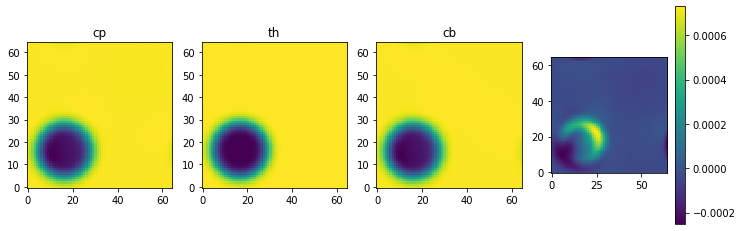

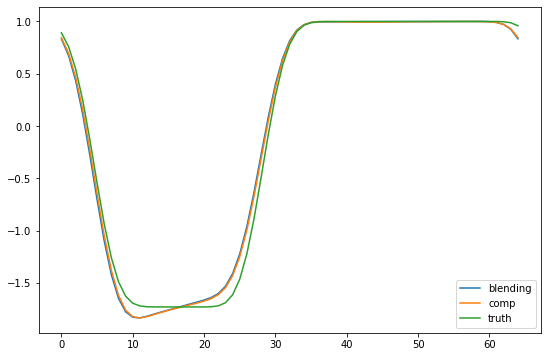

In [334]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, tag, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, tag=tag, label_type='TIME')

Ns = 199
Ns_full = 199
times_full = np.arange(0,Ns+1)
# times = np.array([1,51,101,151])
# times = times[:2]
times = np.arange(0.0,1.001,0.005)
dt = end_time / Ns_full
times_axis = times * dt

attributes = ['p2_nodes', 'rhoY', 'rho', 'rhou', 'rhov', 'buoy']
# attributes = ['dp2n', 'p2_start', 'p2_end']
attributes_str = {
    'p2_nodes': r'$\pi$',
    'rhoY' : r'$P = \rho \theta$',
    'rho' : r'$\rho$',
    'rhou' : r'$\rho u$',
    'rhov' : r'$\rho v$',
    'buoy' : r'$buoy$',
    'p2_start' : 'p2_start',
    'p2_end' : 'p2_end',
    'dp2n' : 'dp2n'
}

cb1, cb1_suffix = [1,0], ''

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    tag = 'before_flux'
#     tag = 'before_advect'
#     tag = 'after_advect'
#     tag = 'after_ebnaexp'
#     tag = 'after_ebnaimp'
#     
    tag = 'after_half_step'
#     tag = 'after_efna'
#     tag = 'after_full_ebnaexp'
    tag = 'after_full_step'

    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    probe = np.array(probe)
    
    if attribute == 'p2_nodes' and increment == True:
        probe = np.diff(probe,axis=0)
    return probe
    
# times_axis = times#np.arange(0,Ns+1)
lst = []
increment = False
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""

    probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     probe_cb1 = get_time_series(times,attribute,'_comp')
    lst.append(probe_cb1)

#     cnt = 0
#     fig1, ax = plt.subplots(ncols=4, figsize=(12,6))
#     for time in times:
#         ax[cnt].imshow(probe_cb1[cnt], origin='lower',aspect='equal')
#         ax[cnt].set_title("time %.3f" %(times_axis[cnt]))
        
#         cnt+=1
#     plt.suptitle("%s" %attribute, y=0.75)
#     plt.show()

starts = lst[1]
ends = lst[2]
    
attributes = ['p2_nodes']
times_full = np.arange(0,Ns+1)
times_full = np.arange(0.0,1.001,0.005)
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""

    probe_truth = get_time_series(times_full,attribute,'_truthgen')
    probe_cb1 = get_time_series(times_full,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     ptobe_cb1 = get_time_series(times_full,attribute,'_comp')
    probe_comp = get_time_series(times_full,attribute,'_comp')
    
cb1 = np.diff(probe_cb1,axis=0)
comp = np.diff(probe_comp,axis=0)

# cnt = 0
# for cnt in range(cb1.shape[0]):
# #     if cnt in times:
#     plt.figure()
#     plt.imshow(cb1[cnt], origin='lower')
#     plt.colorbar()
#     plt.savefig('../output_images/p2_diff/%.3d.png' %cnt)
# #         plt.show()
#     cnt += 1
#     plt.close()

# for time in times_full:
#     fig, ax = plt.subplots(ncols=3, figsize=(12,8))
# #     ax[0].imshow(probe_comp[time], origin='lower')
# #     ax[1].imshow(probe_cb1[time], origin='lower')
# #     im2, ax[2].imshow(probe_cb1[time] - probe_comp[time])
#     ax[0].imshow(comp[time], origin='lower')
#     ax[1].imshow(cb1[time], origin='lower')
#     im2, ax[2].imshow(cb1[time] - comp[time], origin='lower')
#     plt.colorbar(im2, ax=ax[2], shrink=.3)
#     plt.suptitle("%.3f" %times_axis[cnt])
#     plt.show()
    
import scipy.ndimage as sciim

idx0 = 150
idx1 = 150
idx2 = 150
inner = (slice(2,-2),slice(2,-2))
fig,ax=plt.subplots(ncols=4, figsize=(12,8))
cb = probe_cb1[idx0][inner]
cb -= cb.mean()
cp = probe_comp[idx1][inner]
cp -= cp.mean()
th = probe_truth[idx2][inner]
th -= th.mean()
# cb = sciim.shift(cb, 3./16, mode='wrap')
# th = sciim.shift(th, -4./16, mode='wrap')
im0 = ax[0].imshow(cp, origin='lower')
ax[0].set_title("cp")

# im1 = ax[1].imshow(cp, origin='lower')
# ax[1].set_title("cp")
# im2 = ax[2].imshow(cb - cp, origin='lower')
# plt.colorbar(im2, ax=ax[2], shrink=.5)

im1 = ax[1].imshow(th, origin='lower')
ax[1].set_title("th")

im2 = ax[2].imshow(cb, origin='lower')
ax[2].set_title("cb")

im3 = ax[3].imshow(cp - th, origin='lower')
plt.colorbar(im3, ax=ax[3], shrink=.5)

plt.show()

idx = 15
slc = slice(35,45)
slc = slice(None,)
plt.figure(figsize=(9,6))
cbp =cb[idx]-cb[idx].mean()
cbp /= cbp.max()
cpp = cp[idx] - cp[idx].mean()
cpp /= cpp.max()
# cbp = sciim.shift(cbp,-1./16)

thp = th[idx] - th[idx].mean()
thp /= thp.max()
# thp = sciim.shift(thp,-4./16)

plt.plot(cbp[slc], '-', label='blending')
plt.plot(cpp[slc], '-', label='comp')
plt.plot(thp[slc], '-', label='truth')
# plt.plot(cbp - cpp, label='diff')
plt.legend()
plt.show()

# cnt = 0
# m1 = np.array([probe_cb1[cnt] for cnt in times])
# for time in times:
#     fig, ax = plt.subplots(ncols=3, figsize=(12,8))
#     diffs = (0.0 * ends[cnt] + 4.0 * starts[cnt]) / 4.0
    
# #     diffs = (diffs - diffs.mean()) - (m1[cnt] - m1[cnt].mean())
# #     diffs = m1[0] #- m1[0]
#     print(time)
#     diffs0 = probe_comp[time]
#     im0 = ax[0].imshow(diffs, origin='lower')
#     plt.colorbar(im0, ax=ax[0], shrink=.3)
#     ax[0].set_title("blend, %.3f" %times_axis[cnt])
    
#     im1 = ax[1].imshow(diffs0, origin='lower')
#     plt.colorbar(im1, ax=ax[1], shrink=.3)
#     ax[1].set_title("comp, %.3f" %times_axis[cnt])
    
#     im2 = ax[2].imshow(diffs0 - diffs, origin='lower')
#     plt.colorbar(im2, ax=ax[2], shrink=.3)
#     ax[2].set_title("comp, %.3f" %times_axis[cnt])
#     plt.show()
#     cnt += 1

In [45]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

grid_x = 32
grid_y = 32
size = 1
ref_size = 1
end_time = 1.0
fn = get_filename(grid_x,grid_y,size,end_time,'_truth')
py_path_ref_1 = get_path(fn)

attribute = 'rho'
comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='STEP')

arr = np.fft.fft2(comp_ref_0)
arr00 = np.copy(arr[0,0])

arr = np.fft.fftshift(arr)

print(arr[17:20,17:20].real)

slc = (slice(18-1,18+2),slice(18-1,18+2))
print(slc)
arr[17:20,17:20] += 3.0 * np.random.random(arr[17:20,17:20].shape)
arr = np.fft.ifftshift(arr)
arr[0,0] = arr00
arr = np.fft.ifft2(arr).real

fig = plt.figure()
plt.imshow(arr.real, origin='lower')
plt.colorbar()
plt.show()

fig = plt.figure()
plt.imshow(arr - comp_ref_0, origin='lower')
plt.colorbar()
plt.show()



NameError: name 'get_filename' is not defined

[['rho', 'rho'], ['rhou', 'rhou'], ['rhow', 'rhov'], ['rhoY', 'rhoY'], ['buoy', 'buoy'], ['p2_nodes', 'p2_nodes']]
['rho', 'rho']
['rhou', 'rhou']
['rhow', 'rhov']
['rhoY', 'rhoY']
['buoy', 'buoy']
['p2_nodes', 'p2_nodes']


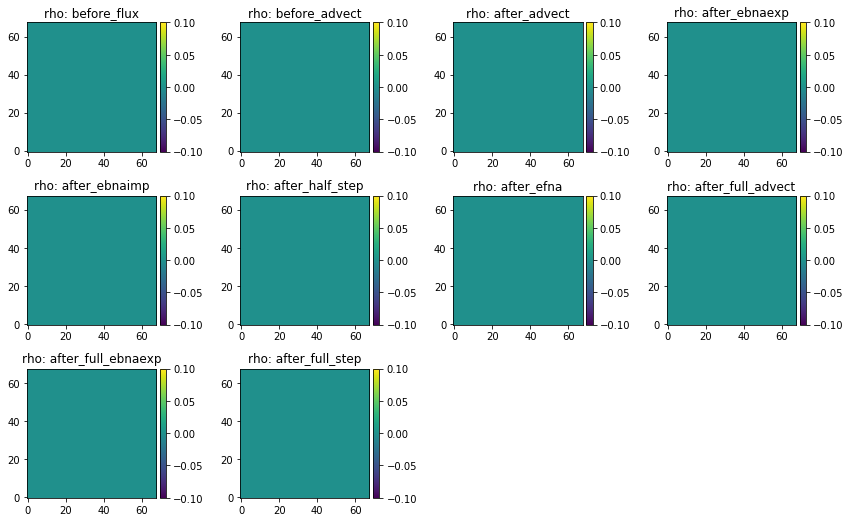

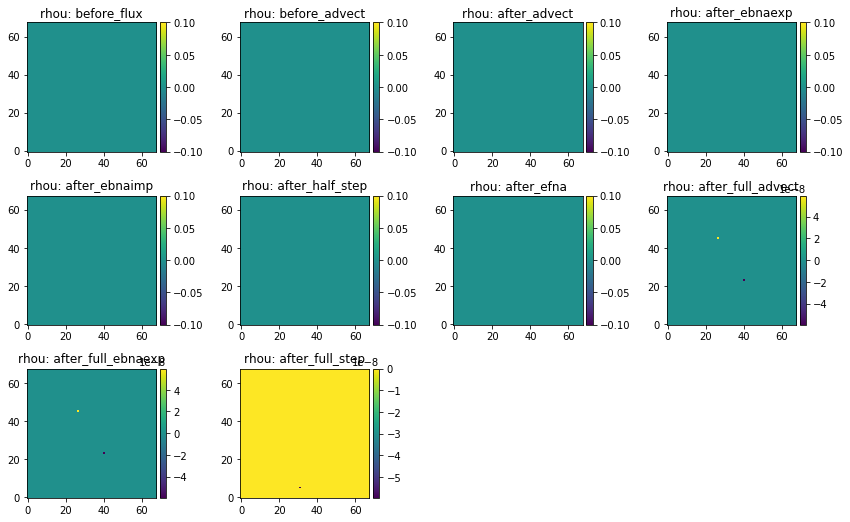

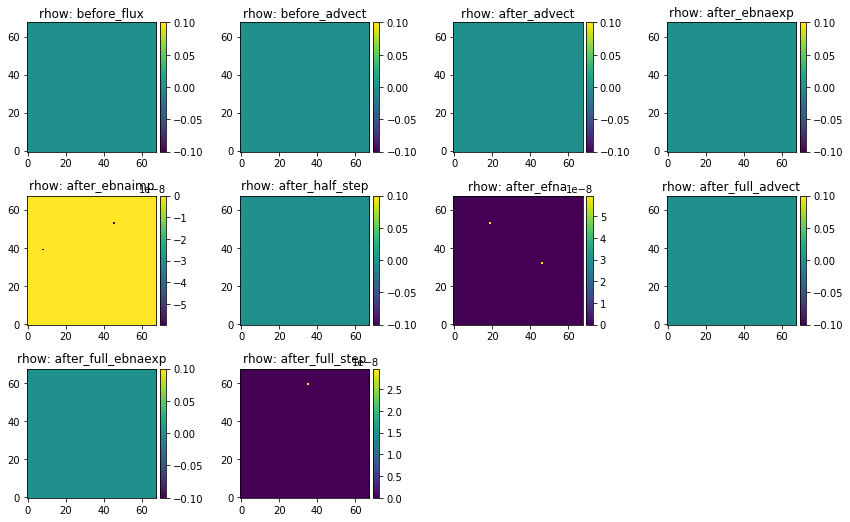

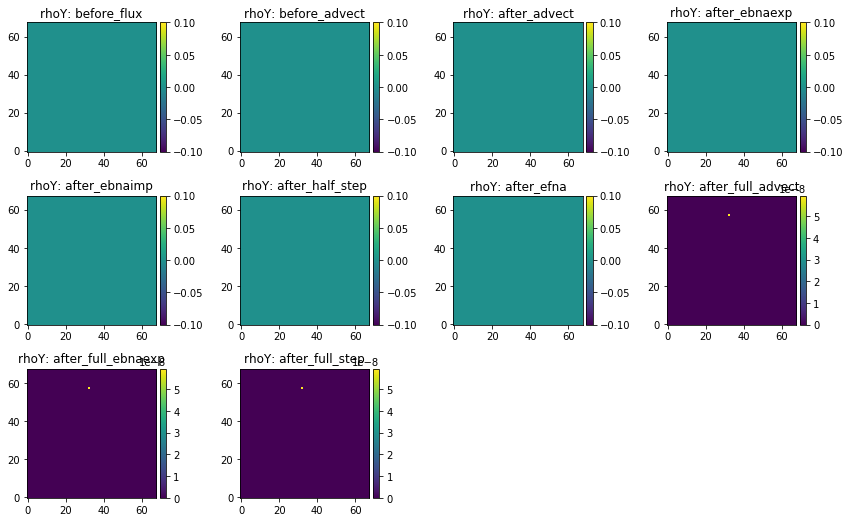

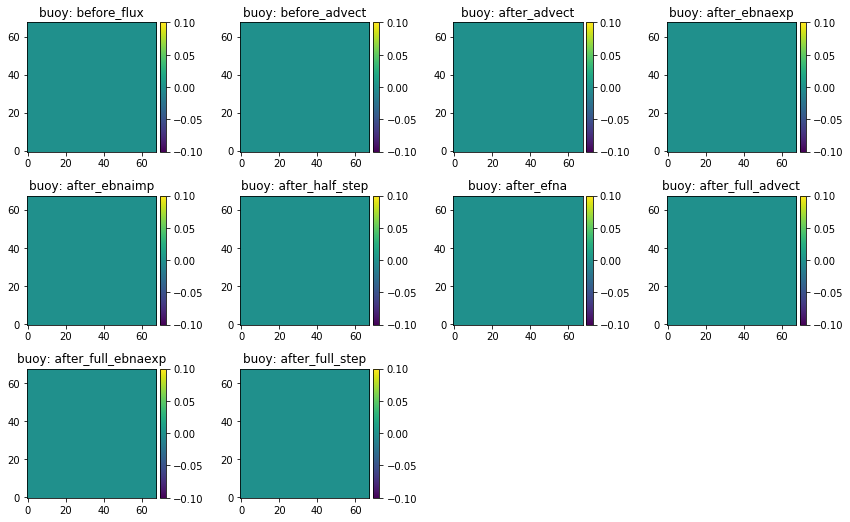

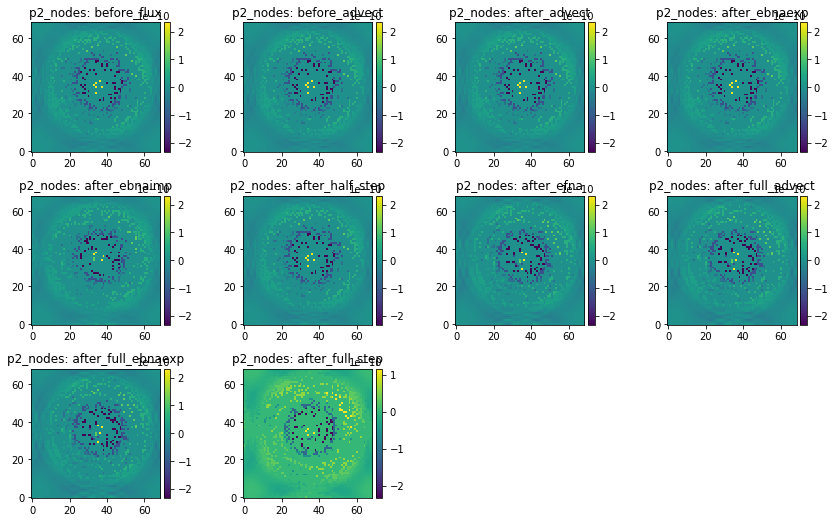

In [276]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx = 64
Ny = 2
et = 1.0
N = 1

tc3D = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=64)

tags2d = tc3D.get_tag_dict()
tags3d = tags2d
# tag = ['after_ebnaimp','after_full_step']
# tags2d = ['before_advect', 'after_half_step']
# tags3d = ['before_advect', 'after_half_step']
# tag = ['split_0']
# tags2d = ['half_split_0', 'half_split_1']
# tags3d = ['half_split_0', 'half_split_2']
tags = [[tags3d[n],tags2d[n]] for n in range(len(tags3d))]

dtag = tc3D.get_debug_attrs()

fn = tc3D.get_filename(N,'3D')
path_3D = tc3D.get_path(fn)

Nx, Ny = 64, 64
tc2D = utils.test_case(base_fn,py_directory,Nx,Ny,et)

fn = tc2D.get_filename(N,'2D')
path_2D = tc2D.get_path(fn)

# attrs2d = ['rho', 'rhou', 'rhov', 'rhov', 'rhoYu', 'rhoYv', 'rhoYv', 'rhoY']
# attrs3d = ['rho', 'rhou', 'rhow', 'rhov', 'rhoYu', 'rhoYw', 'rhoYv', 'rhoY']
attrs2d = ['rho', 'rhou', 'rhov', 'rhoY', 'buoy', 'p2_nodes']
attrs3d = ['rho', 'rhou', 'rhow', 'rhoY', 'buoy', 'p2_nodes']

attributes = [[attrs3d[n],attrs2d[n]] for n in range(len(attrs3d))]
print(attributes)
# attributes = list(tag.values())
# attributes = list(dtag.values())
# attributes.remove('wplusy')
# attributes.remove('wplusz')
step = 9
slc = 3

for attribute in attributes:
    print(attribute)
    arr_lst = []
    for ii in range(len(tags)):
#         tag0 = 'split_0'
#         print(tags[ii])
        arr_3D = tc3D.get_arr(path_3D, step, N, attribute[0], label_type='STEP', tag=tags[ii][0], inner=False)
#         print(arr_3D.shape)
        if attribute[0] == 'rhoYu':
            arr_3D = arr_3D[slc,:,:]
        elif attribute[0] == 'rhoYw':
            arr_3D = arr_3D[:,slc,:]
        elif tags[ii][0] == 'half_split_0':
            arr_3D = arr_3D[slc,:,:]
#         elif tags[ii][0] == 'half_split_2':
        else:
            arr_3D = arr_3D[:,slc,:]
        
        
#         tag0 = 'split_0'
        arr_2D = tc2D.get_arr(path_2D, step, N, attribute[1], label_type='STEP', tag=tags[ii][1], inner=False)
        arr_lst.append([arr_3D-arr_2D,attribute[0] + ': ' + tags[ii][0]])
#         arr_lst.append([arr_3D,attribute[0] + ': ' + tag[ii]])
#         if tag[ii] == 'before_advect' and attribute[0] == 'rho':
#             rho = arr_3D

            
        
# print(np.where(rho==0))
    
    pl = pt.plotter(arr_lst)
    pl.plot(fontsize=10)
    

[['rho', 'rho'], ['rhou', 'rhou'], ['rhow', 'rhov'], ['rhoY', 'rhoY'], ['buoy', 'buoy'], ['p2_nodes', 'p2_nodes']]


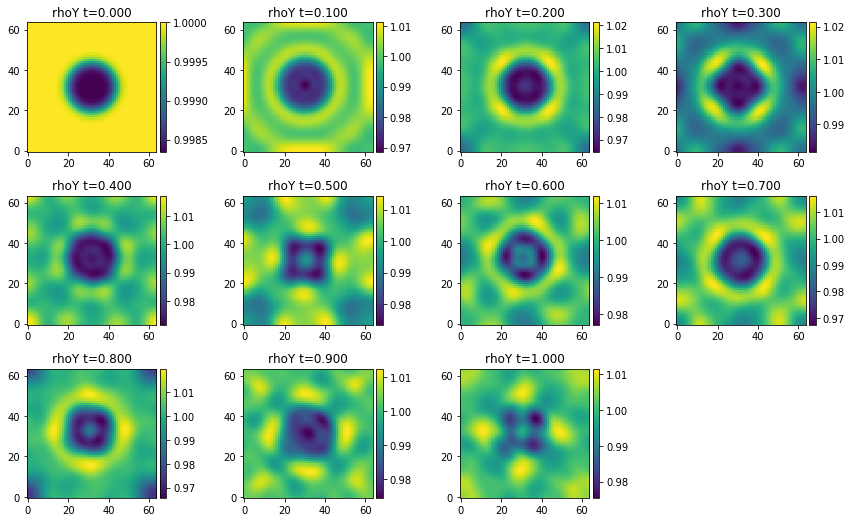

In [369]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx = 64
Ny = 2
et = 1.0
N = 1

tc3D = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=64)

tags2d = tc3D.get_tag_dict()
tags3d = tags2d

tags = [[tags3d[n],tags2d[n]] for n in range(len(tags3d))]

dtag = tc3D.get_debug_attrs()

fn = tc3D.get_filename(N,'3D_corr_ip')
path_3D = tc3D.get_path(fn)

Nx, Ny = 64, 64
tc2D = utils.test_case(base_fn,py_directory,Nx,Ny,et)

fn = tc2D.get_filename(N,'2D')
path_2D = tc2D.get_path(fn)

attrs2d = ['rho', 'rhou', 'rhov', 'rhoY', 'buoy', 'p2_nodes']
attrs3d = ['rho', 'rhou', 'rhow', 'rhoY', 'buoy', 'p2_nodes']

attributes = [[attrs3d[n],attrs2d[n]] for n in range(len(attrs3d))]
print(attributes)

# times = np.arange(0,177)
# times = times[::10]
times = np.arange(0.0,1.001,0.1)
slc = 0

lst = np.zeros((len(attrs3d), times.shape[0]), dtype='object')

for ii,time in enumerate(times):
    for nn,attribute in enumerate(attributes):
        
        arr_3D = tc3D.get_arr(path_3D, time, N, attribute[0], label_type='TIME', tag=tags[-1][0], inner=True)
        arr_3D = arr_3D[:,slc,:]
        
        arr_2D = tc2D.get_arr(path_2D, time, N, attribute[1], label_type='TIME', tag=tags[-1][1], inner=True)
        lst[nn,ii] = [arr_3D, attribute[0] + ' t=%.3f' %time]
        
        

pl = pt.plotter(lst[3])
pl.plot(fontsize=10)
    

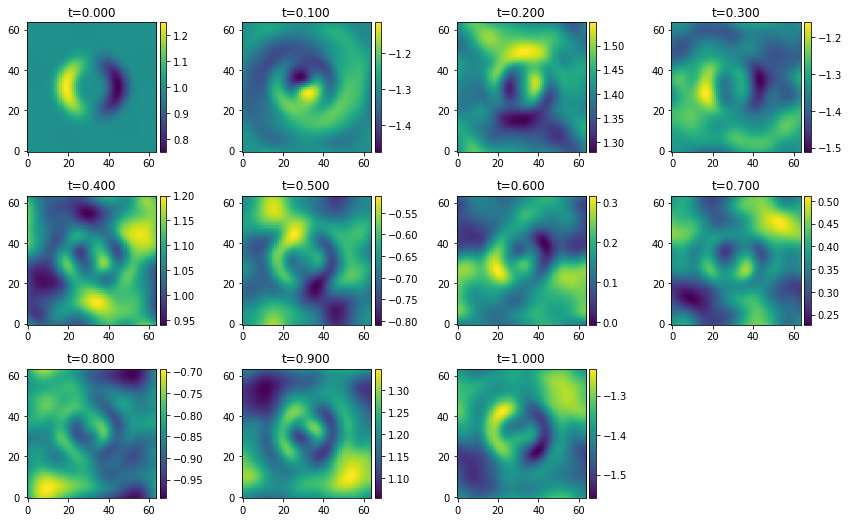

In [375]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx = 64
Ny = 2
et = 1.0
N = 1

tc3D = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=64)
tags3d = list(tc3D.get_tag_dict().values())

dtag = tc3D.get_debug_attrs()

fn = tc3D.get_filename(N,'3D_corr_ip')
path_3D = tc3D.get_path(fn)

attrs3d = ['rho', 'rhou', 'rhow', 'rhoY', 'buoy', 'p2_nodes']

times = np.arange(0.0,1.001,0.1)
slc = 0

lst = np.zeros((len(attrs3d), times.shape[0]), dtype='object')

ulst, vlst = [], []
for ii,time in enumerate(times):
#     for nn,attribute in enumerate(attributes):
        
    rho = tc3D.get_arr(path_3D, time, N, attrs3d[0], label_type='TIME', tag=tags3d[-1], inner=True)
    rho = rho[:,slc,:]
    
    rhou = tc3D.get_arr(path_3D, time, N, attrs3d[1], label_type='TIME', tag=tags3d[-1], inner=True)
    rhou = rhou[:,slc,:]
    
    rhov = tc3D.get_arr(path_3D, time, N, attrs3d[2], label_type='TIME', tag=tags3d[-1], inner=True)
    rhov = rhov[:,slc,:]

    u = rhou / rho
    v = rhov / rho
    
    ulst.append([u, 't=%.3f' %time])
    vlst.append([v, 't=%.3f' %time])
        
pl = pt.plotter(ulst)
pl.plot(fontsize=10)

['u', 'u']
['Leftsu', 'Leftsu']
['Rightsu', 'Rightsu']
['Leftsw', 'Leftsv']
['Rightsw', 'Rightsv']
['LeftsrhoY', 'LeftsrhoY']
['RightsrhoY', 'RightsrhoY']
['Diffsu', 'Diffsu']
['Diffsw', 'Diffsv']
['Amplsu', 'Amplsu']
['Amplsw', 'Amplsv']
['Slopesu', 'Slopesu']
['Slopesw', 'Slopesv']


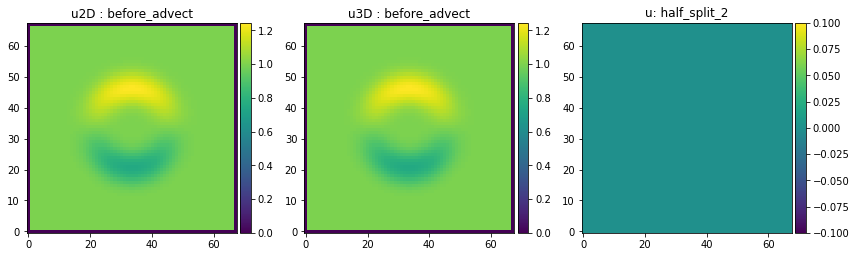

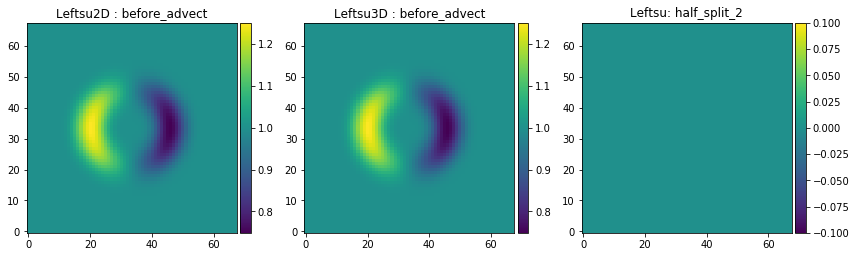

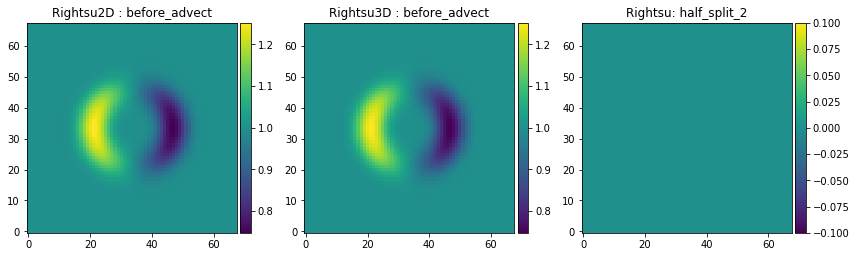

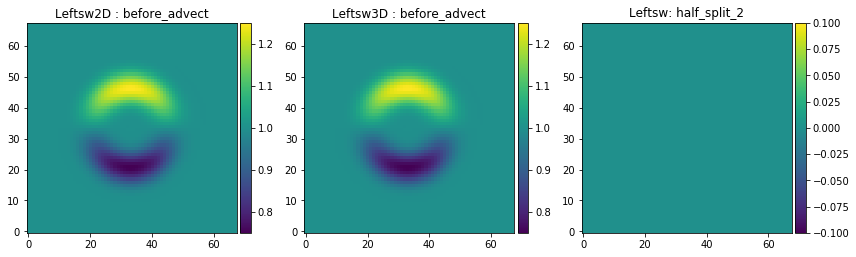

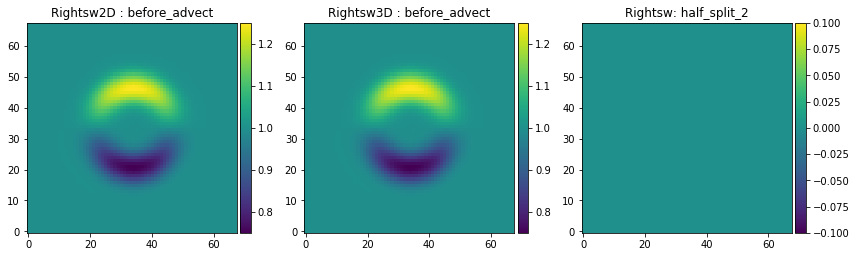

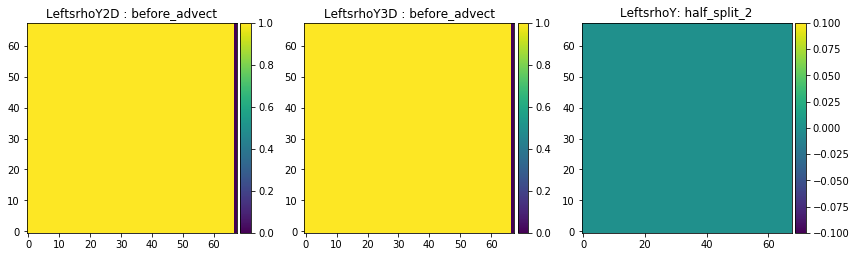

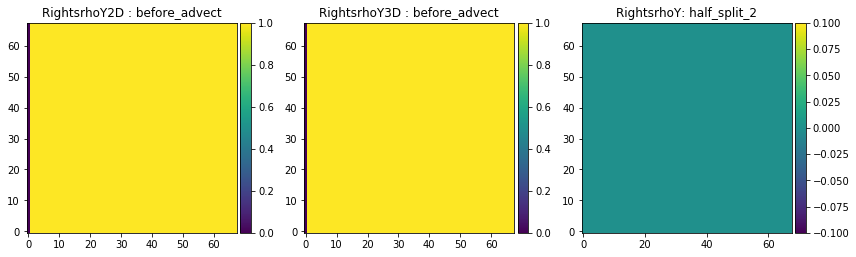

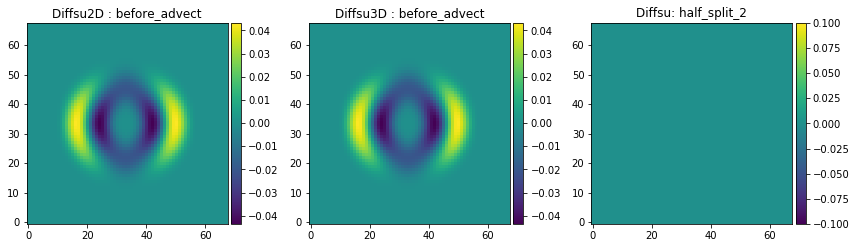

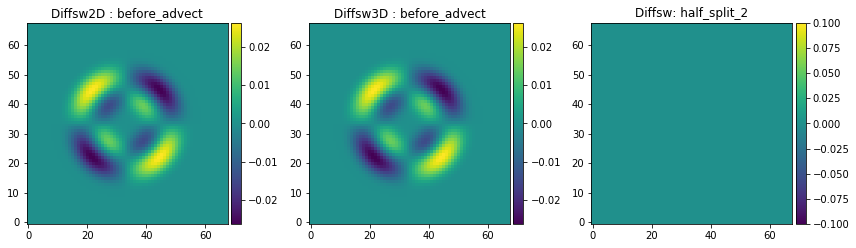

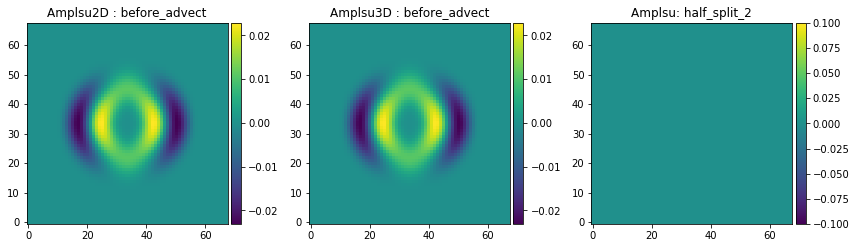

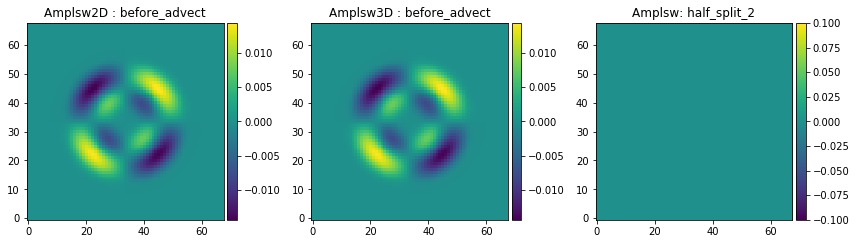

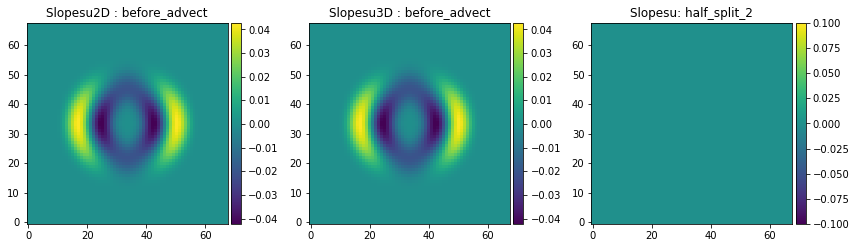

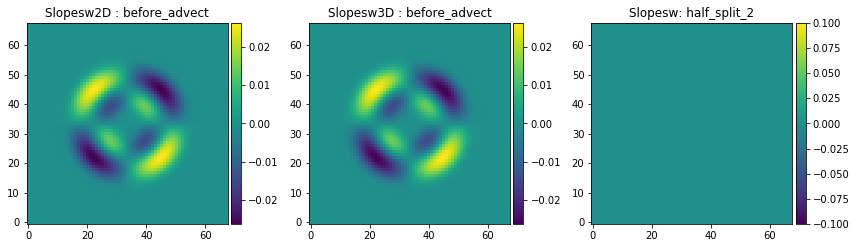

In [272]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx = 64
Ny = 2
et = 1.0
N = 1

tc3D = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=64)

tags2d = tc3D.get_tag_dict()
tags3d = tags2d

# tags2d = ['half_split_0', 'half_split_1']
# tags3d = ['half_split_0', 'half_split_2']

tags2d = ['half_split_1']
tags3d = ['half_split_2']

tags = [[tags3d[n],tags2d[n]] for n in range(len(tags3d))]

dtag = tc3D.get_debug_attrs()

fn = tc3D.get_filename(N,'3D')
path_3D = tc3D.get_path(fn)

Nx, Ny = 64, 64
tc2D = utils.test_case(base_fn,py_directory,Nx,Ny,et)

fn = tc2D.get_filename(N,'2D')
path_2D = tc2D.get_path(fn)

attrs2d = ['u', 'Leftsu', 'Rightsu', 'Leftsv', 'Rightsv', 'LeftsrhoY', 'RightsrhoY']
attrs2d += ['Diffsu', 'Diffsv', 'Amplsu', 'Amplsv', 'Slopesu', 'Slopesv']
attrs3d = ['u', 'Leftsu', 'Rightsu', 'Leftsw', 'Rightsw', 'LeftsrhoY', 'RightsrhoY']
attrs3d += ['Diffsu', 'Diffsw', 'Amplsu', 'Amplsw', 'Slopesu', 'Slopesw']

# attrs2d = ['u']
# attrs3d = ['u']
# attrs2d = ['rhoY']
# attrs3d = ['rhoY']
# attrs3d = ['Leftsu', 'Rightsu', 'Leftsv', 'Rightsv', 'Leftsw', 'Rightsw']
attributes = [[attrs3d[n],attrs2d[n]] for n in range(len(attrs3d))]
# attributes = [[attrs3d[n],attrs2d[n]] for n in range(len(attrs3d))]
step = 0
slc = 3

for attribute in attributes:
    print(attribute)
    arr_lst = []
    for ii in range(len(tags)):
        arr_3D = tc3D.get_arr(path_3D, step, N, attribute[0], label_type='STEP', tag=tags[ii][0], inner=False)
        if attribute[0] == 'rhoYu':
            arr_3D = arr_3D[slc,:,:].T
        elif attribute[0] == 'rhoYw':
            arr_3D = arr_3D[:,slc,:].T
        elif tags[ii][0] == 'half_split_0':
            arr_3D = arr_3D[slc,:,:]
        else:
            arr_3D = arr_3D[:,slc,:]
            
        arr_3D = np.roll(arr_3D, 0,axis=0)
        arr_3D = np.roll(arr_3D, 0,axis=1)
        
        arr_2D = tc2D.get_arr(path_2D, step, N, attribute[1], label_type='STEP', tag=tags[ii][1], inner=False)
        arr_lst.append([arr_2D,attribute[0] + '2D : ' + tag[ii]])
        arr_lst.append([arr_3D,attribute[0] + '3D : ' + tag[ii]])
        arr_lst.append([arr_3D-arr_2D,attribute[0] + ': ' + tags[ii][0]])
        
        if tag[ii] == 'before_advect' and attribute[0] == 'rho':
            rho = arr_3D

# print(np.where(rho==0))
    
    pl = pt.plotter(arr_lst)
    pl.plot(fontsize=10)